Data Preprocessing & Masking

In [1]:
import torch 
from torch.utils.data import DataLoader
from torchvision import datasets , transforms

In [2]:
def get_dataloader( batch_size = 64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((128,128)),
        transforms.Normalize((0.5,),(0.5,))
    ])

    dataset = datasets.CelebA(root = './data' , download = True , split = 'train', transform = transform)
    dataloader = DataLoader(dataset , batch_size = batch_size , shuffle = True)
    return dataloader

In [3]:
def apply_mask(img):
    mask_img = img.clone()
    mask_img[:, :, 32:96,32:96] = 0
    return mask_img

In [4]:
def extracted_patch(img):
    return img[:, :,32:96 , 32:96]

Architecture

In [5]:
import torch.nn as nn

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        def down(in_ft, out_ft, normalize=True):
            layers = [nn.Conv2d(in_ft, out_ft, 4, 2, 1)]
            if normalize: layers.append(nn.BatchNorm2d(out_ft))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers 

        def up(in_ft, out_ft):
            return [
                nn.ConvTranspose2d(in_ft, out_ft, 4, 2, 1),
                nn.BatchNorm2d(out_ft),
                nn.ReLU(inplace=True)
            ]

        self.encoder = nn.Sequential(
            *down(3, 64, normalize=False),
            *down(64, 128),
            *down(128, 256),
            *down(256, 512),
            *down(512, 512),
            nn.Conv2d(512, 4000, 4) 
                    )

        self.decoder = nn.Sequential(
            *up(4000, 512),
            *up(512, 256),
            *up(256, 128),
            *up(128, 64),
            *up(64 , 32),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        def block(in_ft, out_ft):
            return nn.Sequential(
                nn.Conv2d(in_ft, out_ft, 4, 2, 1),
                nn.BatchNorm2d(out_ft),
                nn.LeakyReLU(0.2, inplace=True)
            )

        self.model = nn.Sequential(
            block(3, 64),
            block(64, 128),
            block(128, 256),
            block(256, 512),
            nn.Conv2d(512, 1, 3, 1, 1) 
        )

    def forward(self, x):
        return self.model(x)

Training

In [9]:
import torch.optim as optim

def train_ccgan(dataloader, epochs=20, save_path="ccgan.pth"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    netG = Generator().to(device)
    netD = Discriminator().to(device)
    
    # Initialize weights
    netG.apply(weights_init)
    netD.apply(weights_init)
    
    optG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
    
    criterion_GAN = nn.MSELoss()
    criterion_L1 = nn.L1Loss()

    for epoch in range(epochs):
        for i, (real_imgs, _) in enumerate(dataloader):
            real_imgs = real_imgs.to(device)
            masked_imgs = apply_mask(real_imgs)
            real_patches = extracted_patch(real_imgs)

            # --- Train Discriminator ---
            optD.zero_grad()
            fake_patches = netG(masked_imgs)
            
            pred_real = netD(real_patches)
            loss_D_real = criterion_GAN(pred_real, torch.ones_like(pred_real))
            
            pred_fake = netD(fake_patches.detach())
            loss_D_fake = criterion_GAN(pred_fake, torch.zeros_like(pred_fake))
            
            loss_D = (loss_D_real + loss_D_fake) * 0.5
            loss_D.backward()
            optD.step()

            # --- Train Generator ---
            optG.zero_grad()
            pred_g_fake = netD(fake_patches)
            
            loss_adv = criterion_GAN(pred_g_fake, torch.ones_like(pred_g_fake))
            loss_pixel = criterion_L1(fake_patches, real_patches)
            
            loss_G = loss_adv + (100 * loss_pixel) 
            loss_G.backward()
            optG.step()

        print(f"Epoch [{epoch}/{epochs}] Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}")
        
        # Checkpoint
        torch.save({
            'gen': netG.state_dict(),
            'disc': netD.state_dict(),
            'epoch': epoch
        }, save_path)

Testing

In [10]:
import matplotlib.pyplot as plt

def test_and_plot(image_tensor, model_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    netG = Generator().to(device)
    checkpoint = torch.load(model_path)
    netG.load_state_dict(checkpoint['gen'])
    netG.eval()

    with torch.no_grad():
        img = image_tensor.to(device).unsqueeze(0)
        masked = apply_mask(img)
        fake_patch = netG(masked)
        
        filled = masked.clone()
        filled[:, :, 32:96, 32:96] = fake_patch
        
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].imshow(img[0].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5)
    ax[0].set_title("Original")
    ax[1].imshow(masked[0].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5)
    ax[1].set_title("Masked")
    ax[2].imshow(filled[0].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5)
    ax[2].set_title("CC-GAN Result")
    plt.show()

_______________________________________________________________________________________________________________________________________________________________________________

In [ ]:
loader = get_dataloader(batch_size = 64)
train_ccgan(loader , epochs = 50)

In [ ]:

dataiter = iter(loader)
images, _ = next(dataiter)
rand_img = images[0]

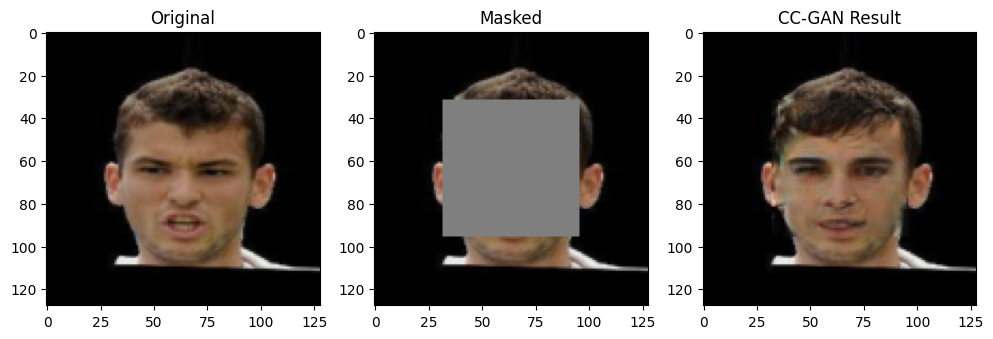

In [ ]:
test_and_plot(rand_img, "ccgan.pth")